<a href="https://colab.research.google.com/github/ReneeDu320/deep_learning/blob/main/optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 随机梯度下降法
前面我们介绍了梯度下降法的数学原理，下面我们通过例子来说明一下随机梯度下降法，我们分别从 0 自己实现，以及使用 pytorch 中自带的优化器

In [ ]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255 # 将数据变到 0 ~ 1 之间
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

随机梯度下降法非常简单，公式就是
$$
\theta_{i+1} = \theta_i - \eta \nabla L(\theta)
$$
非常简单，我们可以从 0 开始自己实现

In [ ]:
def sgd_update(parameters, lr):
    for param in parameters:
        param.data = param.data - lr * param.grad.data

我们可以将 batch size 先设置为 1，看看有什么效果

In [ ]:
train_data = DataLoader(train_set, batch_size=1, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses1 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1e-2) # 使用 0.01 的学习率
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses1.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.350681
epoch: 1, Train Loss: 0.213382
epoch: 2, Train Loss: 0.181885
epoch: 3, Train Loss: 0.160208
epoch: 4, Train Loss: 0.151504
使用时间: 473.28675 s


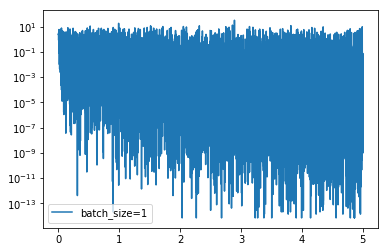

In [ ]:
x_axis = np.linspace(0, 5, len(losses1), endpoint=True)
plt.semilogy(x_axis, losses1, label='batch_size=1')
plt.legend(loc='best')

可以看到，loss 在剧烈震荡，因为每次都是只对一个样本点做计算，每一层的梯度都具有很高的随机性，而且需要耗费了大量的时间

In [ ]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses2 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1e-2)
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses2.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.735301
epoch: 1, Train Loss: 0.362765
epoch: 2, Train Loss: 0.316051
epoch: 3, Train Loss: 0.287766
epoch: 4, Train Loss: 0.264757
使用时间: 40.03663 s


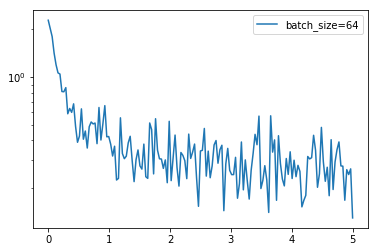

In [ ]:
x_axis = np.linspace(0, 5, len(losses2), endpoint=True)
plt.semilogy(x_axis, losses2, label='batch_size=64')
plt.legend(loc='best')

通过上面的结果可以看到 loss 没有 batch 等于 1 震荡那么距离，同时也可以降到一定的程度了，时间上也比之前快了非常多，因为按照 batch 的数据量计算上更快，同时梯度对比于 batch size = 1 的情况也跟接近真实的梯度，所以 batch size 的值越大，梯度也就越稳定，而 batch size 越小，梯度具有越高的随机性，这里 batch size 为 64，可以看到 loss 仍然存在震荡，但这并没有关系，如果 batch size 太大，对于内存的需求就更高，同时也不利于网络跳出局部极小点，所以现在普遍使用基于 batch 的随机梯度下降法，而 batch 的多少基于实际情况进行考虑

下面我们调高学习率，看看有什么样的结果

In [ ]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses3 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1) # 使用 1.0 的学习率
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses3.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 2.462500
epoch: 1, Train Loss: 2.304734
epoch: 2, Train Loss: 2.305732
epoch: 3, Train Loss: 2.304950
epoch: 4, Train Loss: 2.304857
使用时间: 42.85314 s


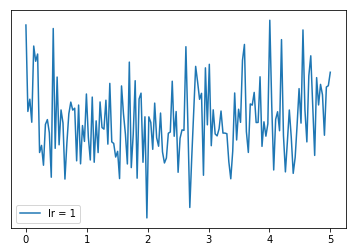

In [ ]:
x_axis = np.linspace(0, 5, len(losses3), endpoint=True)
plt.semilogy(x_axis, losses3, label='lr = 1')
plt.legend(loc='best')

可以看到，学习率太大会使得损失函数不断回跳，从而无法让损失函数较好降低，所以我们一般都是用一个比较小的学习率

实际上我们并不用自己造轮子，因为 pytorch 中已经为我们内置了随机梯度下降发，而且之前我们一直在使用，下面我们来使用 pytorch 自带的优化器来实现随机梯度下降

In [ ]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimzier = torch.optim.SGD(net.parameters(), 1e-2)
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimzier.zero_grad()
        loss.backward()
        optimzier.step()
        # 记录误差
        train_loss += loss.data[0]
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.747158
epoch: 1, Train Loss: 0.364107
epoch: 2, Train Loss: 0.318209
epoch: 3, Train Loss: 0.290282
epoch: 4, Train Loss: 0.268150
使用时间: 46.75882 s


# 动量法
使用梯度下降法，每次都会朝着目标函数下降最快的方向，这也称为最速下降法。这种更新方法看似非常快，实际上存在一些问题。

## 梯度下降法的问题
考虑一个二维输入，$[x_1, x_2]$，输出的损失函数 $L: R^2 \rightarrow R$，可以想象成一个很扁的漏斗，这样在竖直方向上，梯度就非常大，在水平方向上，梯度就相对较小，所以我们在设置学习率的时候就不能设置太大，为了防止竖直方向上参数更新太过了，这样一个较小的学习率又导致了水平方向上参数在更新的时候太过于缓慢，所以就导致最终收敛起来非常慢。

## 动量法
动量法的提出就是为了应对这个问题，我们梯度下降法做一个修改如下

$$
v_i = \gamma v_{i-1} + \eta \nabla L(\theta)
$$
$$
\theta_i = \theta_{i-1} - v_i
$$

其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率


相当于每次在进行参数更新的时候，都会将之前的速度考虑进来，每个参数在各方向上的移动幅度不仅取决于当前的梯度，还取决于过去各个梯度在各个方向上是否一致，如果一个梯度一直沿着当前方向进行更新，那么每次更新的幅度就越来越大，如果一个梯度在一个方向上不断变化，那么其更新幅度就会被衰减，这样我们就可以使用一个较大的学习率，使得收敛更快，同时梯度比较大的方向就会因为动量的关系每次更新的幅度减少。

比如我们的梯度每次都等于 g，而且方向都相同，那么动量法在该方向上使参数加速移动，有下面的公式：

$$
v_0 = 0
$$
$$
v_1 = \gamma v_0 + \eta g = \eta g
$$
$$
v_2 = \gamma v_1 + \eta g = (1 + \gamma) \eta g
$$
$$
v_3 = \gamma v_2 + \eta g = (1 + \gamma + \gamma^2) \eta g
$$
$$
\cdots
$$
$$
v_{+ \infty} = (1 + \gamma + \gamma^2 + \gamma^3 + \cdots) \eta g = \frac{1}{1 - \gamma} \eta g
$$

如果我们把 $\gamma$ 定为 0.9，那么更新幅度的峰值就是原本梯度乘学习率的 10 倍。

本质上说，动量法就仿佛我们从高坡上推一个球，小球在向下滚动的过程中积累了动量，在途中也会变得越来越快，最后会达到一个峰值，对应于我们的算法中就是，动量项会沿着梯度指向方向相同的方向不断增大，对于梯度方向改变的方向逐渐减小，得到了更快的收敛速度以及更小的震荡。

下面我们手动实现一个动量法，公式已经在上面了

In [1]:
def sgd_momentum(parameters, vs, lr, gamma):
    for param, v in zip(parameters, vs):
        v[:] = gamma * v + lr * param.grad.data
        param.data = param.data - v

In [5]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 将速度初始化为和参数形状相同的零张量
vs = []
for param in net.parameters():
    vs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_momentum(net.parameters(), vs, 1e-2, 0.9) # 使用的动量参数为 0.9，学习率 0.01
        # 记录误差
        train_loss += loss.data.item()
        
        losses.append(loss.data.item())
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.372527
epoch: 1, Train Loss: 0.175007
epoch: 2, Train Loss: 0.127150
epoch: 3, Train Loss: 0.102927
epoch: 4, Train Loss: 0.083257
使用时间: 60.67223 s


可以看到，加完动量之后 loss 能下降非常快，但是一定要小心学习率和动量参数，这两个值会直接影响到参数每次更新的幅度，所以可以多试几个值

当然，pytorch 内置了动量法的实现，非常简单，直接在 `torch.optim.SGD(momentum=0.9)` 即可，下面实现一下

In [20]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # 加动量
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0: # 30 步记录一次
            losses.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.371012
epoch: 1, Train Loss: 0.178182
epoch: 2, Train Loss: 0.130258
epoch: 3, Train Loss: 0.102971
epoch: 4, Train Loss: 0.086020
使用时间: 52.36046 s


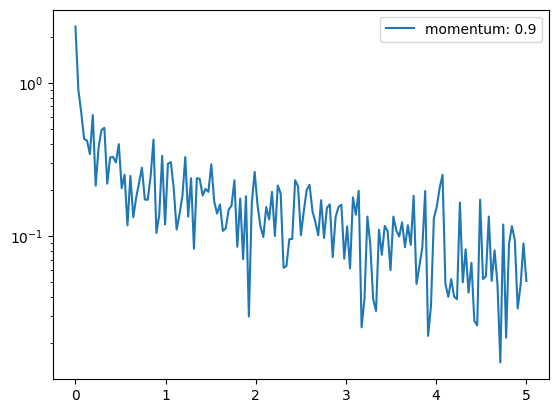

In [10]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.legend(loc='best')

我们可以对比一下不加动量的随机梯度下降法

In [21]:
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2) # 不加动量
# 开始训练
losses1 = []
idx = 0
start = time.time() # 记时开始

for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0: # 30 步记录一次
            losses1.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.745433
epoch: 1, Train Loss: 0.365255
epoch: 2, Train Loss: 0.318754
epoch: 3, Train Loss: 0.291281
epoch: 4, Train Loss: 0.269538
使用时间: 59.71879 s


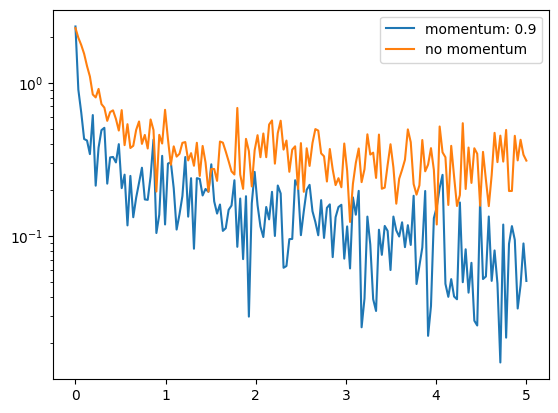

In [13]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.semilogy(x_axis, losses1, label='no momentum')
plt.legend(loc='best')

可以看到加完动量之后的 loss 下降的程度更低了，可以将动量理解为一种惯性作用，所以每次更新的幅度都会比不加动量的情况更多

# Adagrad
这个优化算法被称为自适应学习率优化算法，之前我们讲的随机梯度下降以及动量法对所有的参数都使用的固定的学习率进行参数更新，但是不同的参数梯度可能不一样，所以需要不同的学习率才能比较好的进行训练，但是这个事情又不能很好地被人为操作，所以 Adagrad 便能够帮助我们做这件事。

## Adagrad 算法
Adagrad 的想法非常简答，在每次使用一个 batch size 的数据进行参数更新的时候，我们需要计算所有参数的梯度，那么其想法就是对于每个参数，初始化一个变量 s 为 0，然后每次将该参数的梯度平方求和累加到这个变量 s 上，然后在更新这个参数的时候，学习率就变为

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$

这里的 $\epsilon$ 是为了数值稳定性而加上的，因为有可能 s 的值为 0，那么 0 出现在分母就会出现无穷大的情况，通常 $\epsilon$ 取 $10^{-10}$，这样不同的参数由于梯度不同，他们对应的 s 大小也就不同，所以上面的公式得到的学习率也就不同，这也就实现了自适应的学习率。

Adagrad 的核心想法就是，如果一个参数的梯度一直都非常大，那么其对应的学习率就变小一点，防止震荡，而一个参数的梯度一直都非常小，那么这个参数的学习率就变大一点，使得其能够更快地更新

Adagrad 也有一些问题，因为 s 不断累加梯度的平方，所以会越来越大，导致学习率在后期会变得较小，导致收敛乏力的情况，可能无法收敛到表较好的结果，当然后面有一个对其的改进，我们之后会讲到

下面我们来实现一下 Adagrad 的算法

In [14]:
def sgd_adagrad(parameters, sqrs, lr):
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs):
        sqr[:] = sqr + param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

In [15]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [17]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_adagrad(net.parameters(), sqrs, 1e-2) # 学习率设为 0.01
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0:
            losses.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.413289
epoch: 1, Train Loss: 0.253551
epoch: 2, Train Loss: 0.214221
epoch: 3, Train Loss: 0.189356
epoch: 4, Train Loss: 0.171674
使用时间: 56.61553 s


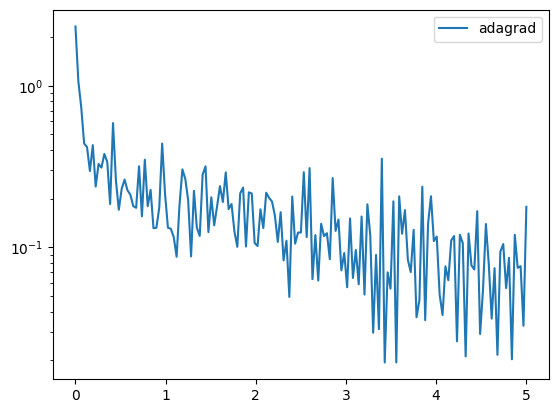

In [25]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='adagrad')
plt.legend(loc='best')

可以看到，使用自适应的学习率跑 5 个 epoch 可以得到比随机梯度下降得到更小的 loss，学习率能够自适应地降低，所以能够有着更好的效果

当然 pytorch 也内置了 adagrad 的优化算法，只需要调用 `torch.optim.Adagrad()` 就可以了，下面是例子

In [30]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
losses2 = []
idx = 0
optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0: # 30 步记录一次
          losses2.append(loss.data.item())
        idx += 1 
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.409262
epoch: 1, Train Loss: 0.258206
epoch: 2, Train Loss: 0.218576
epoch: 3, Train Loss: 0.194437
epoch: 4, Train Loss: 0.177983
使用时间: 53.33776 s


# RMSProp
RMSprop 是由 Geoff Hinton 在他 Coursera 课程中提出的一种适应性学习率方法，至今仍未被公开发表。前面我们提到了 Adagrad 算法有一个问题，就是学习率分母上的变量 s 不断被累加增大，最后会导致学习率除以一个比较大的数之后变得非常小，这不利于我们找到最后的最优解，所以 RMSProp 的提出就是为了解决这个问题。

## RMSProp 算法
RMSProp 仍然会使用梯度的平方量，不同于 Adagrad，其会使用一个指数加权移动平均来计算这个 s，也就是

$$
s_i = \alpha s_{i-1} + (1 - \alpha) \ g^2
$$

这里 g 表示当前求出的参数梯度，然后最终更新和 Adagrad 是一样的，学习率变成了

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$

这里 $\alpha$ 是一个移动平均的系数，也是因为这个系数，导致了 RMSProp 和 Adagrad 不同的地方，这个系数使得 RMSProp 更新到后期累加的梯度平方较小，从而保证 s 不会太大，也就使得模型后期依然能够找到比较优的结果

实现上和 Adagrad 非常像

In [29]:
def rmsprop(parameters, sqrs, lr, alpha):
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs):
        sqr[:] = alpha * sqr + (1 - alpha) * param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

In [33]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), sqrs, 1e-3, 0.9) # 学习率设为 0.001，alpha 设为 0.9
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0:
            losses.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.385560
epoch: 1, Train Loss: 0.175497
epoch: 2, Train Loss: 0.128212
epoch: 3, Train Loss: 0.105890
epoch: 4, Train Loss: 0.091252
使用时间: 60.36173 s


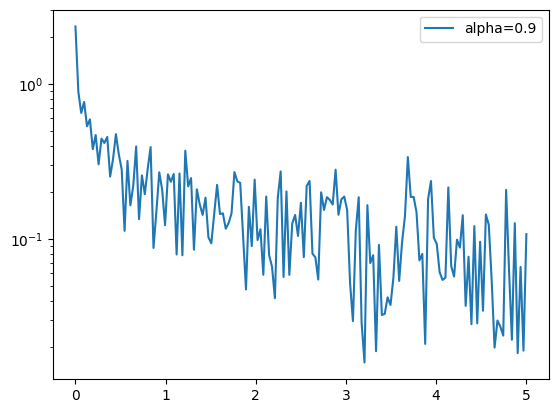

In [34]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='alpha=0.9')
plt.legend(loc='best')

In [35]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, alpha=0.9)
    
# 开始训练
losses3 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0: # 30 步记录一次
          losses3.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.372193
epoch: 1, Train Loss: 0.165109
epoch: 2, Train Loss: 0.121096
epoch: 3, Train Loss: 0.099499
epoch: 4, Train Loss: 0.088205
使用时间: 79.89097 s


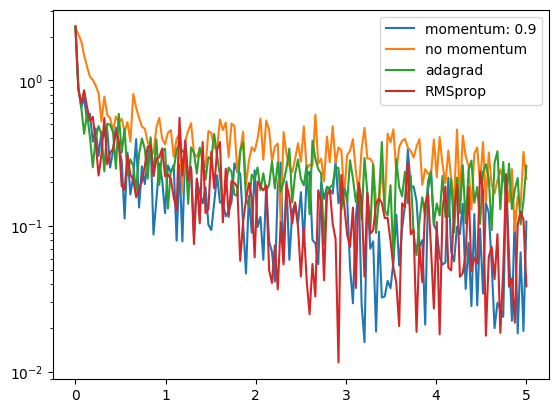

In [36]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.semilogy(x_axis, losses1, label='no momentum')
plt.semilogy(x_axis, losses2, label='adagrad')
plt.semilogy(x_axis, losses3, label='RMSprop')
plt.legend(loc='best')

# Adadelta
Adadelta 算是 Adagrad 法的延伸，它跟 RMSProp 一样，都是为了解决 Adagrad 中学习率不断减小的问题，RMSProp 是通过移动加权平均的方式，而 Adadelta 也是一种方法，有趣的是，它并不需要学习率这个参数。

## Adadelta 法
Adadelta 跟 RMSProp 一样，先使用移动平均来计算 s

$$
s = \rho s + (1 - \rho) g^2
$$

这里 $\rho$ 和 RMSProp 中的 $\alpha$ 都是移动平均系数，g 是参数的梯度，然后我们会计算需要更新的参数的变化量

$$
g' = \frac{\sqrt{\Delta \theta + \epsilon}}{\sqrt{s + \epsilon}} g
$$

$\Delta \theta$ 初始为 0 张量，每一步做如下的指数加权移动平均更新

$$
\Delta \theta = \rho \Delta \theta + (1 - \rho) g'^2
$$

最后参数更新如下

$$
\theta = \theta - g'
$$

下面我们实现以下 Adadelta

In [37]:
def adadelta(parameters, sqrs, deltas, rho):
    eps = 1e-6
    for param, sqr, delta in zip(parameters, sqrs, deltas):
        sqr[:] = rho * sqr + (1 - rho) * param.grad.data ** 2
        cur_delta = torch.sqrt(delta + eps) / torch.sqrt(sqr + eps) * param.grad.data
        delta[:] = rho * delta + (1 - rho) * cur_delta ** 2
        param.data = param.data - cur_delta

In [38]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.Adadelta(net.parameters(), rho=0.9)

losses4 = []
idx = 0
# 开始训练
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0: # 30 步记录一次
          losses4.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.362669
epoch: 1, Train Loss: 0.162016
epoch: 2, Train Loss: 0.122284
epoch: 3, Train Loss: 0.105224
epoch: 4, Train Loss: 0.089266
使用时间: 61.07328 s


# Adam
Adam 是一个结合了动量法和 RMSProp 的优化算法，其结合了两者的优点。

## Adam 算法
Adam 算法会使用一个动量变量 v 和一个 RMSProp 中的梯度元素平方的移动指数加权平均 s，首先将他们全部初始化为 0，然后在每次迭代中，计算他们的移动加权平均进行更新

$$
v = \beta_1 v + (1 - \beta_1) g \\
s = \beta_2 s + (1 - \beta_2) g^2
$$

在 adam 算法里，为了减轻 v 和 s 被初始化为 0 的初期对计算指数加权移动平均的影响，每次 v 和 s 都做下面的修正

$$
\hat{v} = \frac{v}{1 - \beta_1^t} \\
\hat{s} = \frac{s}{1 - \beta_2^t}
$$

这里 t 是迭代次数，可以看到，当 $0 \leq \beta_1, \beta_2 \leq 1$ 的时候，迭代到后期 t 比较大，那么 $\beta_1^t$ 和 $\beta_2^t$ 就几乎为 0，就不会对 v 和 s 有任何影响了，算法作者建议$\beta_1 = 0.9$, $\beta_2 = 0.999$。

最后使用修正之后的 $\hat{v}$ 和 $\hat{s}$ 进行学习率的重新计算

$$
g' = \frac{\eta \hat{v}}{\sqrt{\hat{s} + \epsilon}}
$$

这里 $\eta$ 是学习率，$epsilon$ 仍然是为了数值稳定性而添加的常数，最后参数更新有

$$
\theta_i = \theta_{i-1} - g'
$$

In [39]:
def adam(parameters, vs, sqrs, lr, t, beta1=0.9, beta2=0.999):
    eps = 1e-8
    for param, v, sqr in zip(parameters, vs, sqrs):
        v[:] = beta1 * v + (1 - beta1) * param.grad.data
        sqr[:] = beta2 * sqr + (1 - beta2) * param.grad.data ** 2
        v_hat = v / (1 - beta1 ** t)
        s_hat = sqr / (1 - beta2 ** t)
        param.data = param.data - lr * v_hat / torch.sqrt(s_hat + eps)

In [41]:

# 初始化梯度平方项和动量项
sqrs = []
vs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    vs.append(torch.zeros_like(param.data))
t = 1
# 开始训练
losses = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        adam(net.parameters(), vs, sqrs, 1e-3, t) # 学习率设为 0.001
        t += 1
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0:
            losses.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.357635
epoch: 1, Train Loss: 0.179497
epoch: 2, Train Loss: 0.129412
epoch: 3, Train Loss: 0.104159
epoch: 4, Train Loss: 0.087481
使用时间: 80.46232 s


可以看到使用 adam 算法 loss 能够更快更好地收敛，但是一定要小心学习率的设定，使用自适应的算法一般需要更小的学习率

当然 pytorch 中也内置了 adam 的实现，只需要调用 `torch.optim.Adam()`，下面是例子

In [42]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
# 开始训练
losses5 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data.item()
        if idx % 30 == 0: # 30 步记录一次
          losses5.append(loss.data.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.079108
epoch: 1, Train Loss: 0.068167
epoch: 2, Train Loss: 0.061358
epoch: 3, Train Loss: 0.053452
epoch: 4, Train Loss: 0.049103
使用时间: 54.92075 s


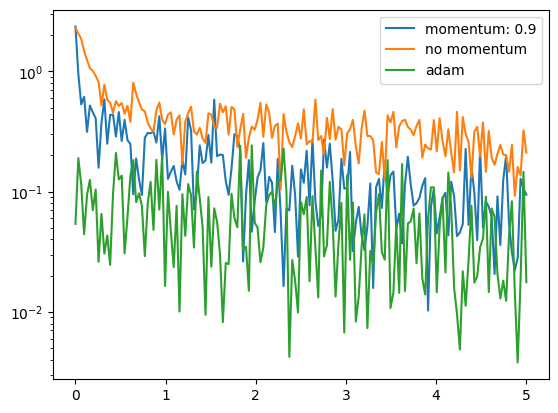

In [48]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.semilogy(x_axis, losses1, label='no momentum')
#plt.semilogy(x_axis, losses3, label='RMSprop')
#plt.semilogy(x_axis, losses4, label='adadelta')
plt.semilogy(x_axis, losses5, label='adam')
plt.legend(loc='best')